In [1]:
import os
import pandas as pd
import cv2
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt 
import time
import re

In [2]:
def show_info_from_file_name(image_path):
    if image_path[:7]=='./Canny':
        matcher=re.compile(r'(?<=\./Canny_Filtered_Images/).*(?=_)')
        matched=matcher.findall(image_path)
        designer_look_season=matched[0].split('_')
    return designer_look_season

In [3]:
xkcd_color_list=pd.read_pickle('./xkcd_rgb.pkl')
# Finds closest colors from XKCD list
def color_from_xkcd(centers=list(),
                    counts=list(),
                    xkcd_color_list=xkcd_color_list,
                    num_predefined_colors = 152):
    closest_colors=pd.DataFrame(columns=xkcd_color_list.keys())
    original=pd.DataFrame(columns=['original','distance','frequency'])
    for i,color in enumerate(centers):
        min_distance = 256**3
        closest_color= ''
        for _,xkcd_color in xkcd_color_list.tail(num_predefined_colors).iterrows():
            distance=((int(xkcd_color['decimal'][0])-int(color[0]))**2+(int(xkcd_color['decimal'][1])-int(color[1]))**2+(int(xkcd_color['decimal'][2])-int(color[2]))**2)**.5
            if distance<min_distance:
                min_distance=distance
                closest_color=xkcd_color
                closest_color_name=closest_color['colors']
        closest_colors=closest_colors.append(closest_color,ignore_index=True)
        try: original=original.append({'original':color,'distance':min_distance,'frequency':counts[i]},ignore_index=True)
        except IndexError: 
            print('Got an Index Error @ '+ str(i))
            return
    return closest_colors.merge(right=original,right_index=True,left_index=True,how='outer')

In [22]:
def dominant_colors(image_path, n_clusters=20, max_iter =300, random_state=42, n_jobs =1,plot=False):
    #convert bgr
    img=cv2.imread(image_path)            # read as BGR
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])         # convert to RGB
    
    #reshape image to a list of pixels
    img = img.reshape((img.shape[0]*img.shape[1],3))

    #Cluster 
    kmc = KMeans(n_clusters=n_clusters,
             max_iter=max_iter, 
             random_state = random_state,
            n_jobs=n_jobs)
    kmc.fit(img)
    
    centers=kmc.cluster_centers_.astype(int)
    labels=np.unique(kmc.labels_)
    counts = np.bincount(kmc.labels_)
    
    # Deletes clusters that are exactly black
    for i,x in enumerate(centers):
        if not x.all():
            centers=np.delete(centers,i,0)
            labels=np.delete(labels,i,0)
            counts=np.delete(counts,i,0)
            break
            
    approximate_color_names = color_from_xkcd(centers=centers,
                                              counts=counts,
                                              xkcd_color_list=xkcd_color_list)
    
        
    #add frequency_ratio
    total_pixels=approximate_color_names['frequency'].sum()
    approximate_color_names['image_pixel_ratio']=approximate_color_names.frequency.apply(lambda x:x/total_pixels)
    
    
    #add designer, look, and season
    designer_look_season=show_info_from_file_name(image_path)
    approximate_color_names['designer']=designer_look_season[0]
    approximate_color_names['look']=designer_look_season[1]
    approximate_color_names['season']=designer_look_season[2]
    approximate_color_names['image_path']=image_path

    if plot:
        fig,ax = plt.subplots()
        plt.axis('off')
        ind=np.arange(0,n_clusters)
        barlist=plt.bar(x=range(counts.shape[0]),height=counts)
        for x in range(counts.shape[0]):
            barlist[x].set_color(centers[x]/255)
        
        
    
    return approximate_color_names


In [6]:
image_paths=pd.read_csv('./Canny_Filtered_Images/directory1.csv').canny_image_path

In [18]:
errors = []

In [19]:
#Run this cell if you have 35,000 seconds to spare
#This is going to extract all the colors from all the pictures and save in a dataframe
start=time.time()
iterations=len(image_paths)
for i,image_path in enumerate(image_paths):
    if i <826: 
        continue
    try: approximate_color_names=dominant_colors(image_path)
    except TypeError: 
        print("An error was thrown at "+image_path)
        errors.append(image_path)
        continue
        
    if i==0: all_colors_and_shows=approximate_color_names.copy()
    else:
        all_colors_and_shows=all_colors_and_shows.append(approximate_color_names)
        approximate_color_names=''
        
        
        
    if i%10 ==1:
        current = time.time()
        elapsed= current-start
        average= elapsed/i
        minutes_left = (iterations-i)*average/60
        print("{0:.2f} seconds have passed after {1:.2f} iterations. About {2:.2f} minutes left".format(elapsed,i,minutes_left))
end = time.time()
print('this process took {0:.2f} seconds'.format(end-start))
all_colors_and_shows.to_csv('./all_colors_and_shows.csv')
all_colors_and_shows.to_pickle('./all_colors_and_shows.pkl')

Got an Index Error @ 0
An error was thrown at ./Canny_Filtered_Images/Balenciaga_Fall 2017 Ready-to-Wear_Look 46_detected.jpgcanny.jpg
11.46 seconds have passed after 831.00 iterations. About 4.02 minutes left
32.10 seconds have passed after 841.00 iterations. About 11.13 minutes left
55.94 seconds have passed after 851.00 iterations. About 19.16 minutes left
74.19 seconds have passed after 861.00 iterations. About 25.09 minutes left
91.65 seconds have passed after 871.00 iterations. About 30.63 minutes left
105.18 seconds have passed after 881.00 iterations. About 34.73 minutes left
119.94 seconds have passed after 891.00 iterations. About 39.14 minutes left
135.13 seconds have passed after 901.00 iterations. About 43.58 minutes left
152.94 seconds have passed after 911.00 iterations. About 48.75 minutes left
176.12 seconds have passed after 921.00 iterations. About 55.50 minutes left
193.22 seconds have passed after 931.00 iterations. About 60.20 minutes left
214.93 seconds have pass

2877.36 seconds have passed after 1851.00 iterations. About 427.07 minutes left
2886.86 seconds have passed after 1861.00 iterations. About 425.92 minutes left
2894.98 seconds have passed after 1871.00 iterations. About 424.58 minutes left
2903.72 seconds have passed after 1881.00 iterations. About 423.34 minutes left
2912.91 seconds have passed after 1891.00 iterations. About 422.17 minutes left
2921.97 seconds have passed after 1901.00 iterations. About 421.00 minutes left
2932.21 seconds have passed after 1911.00 iterations. About 420.01 minutes left
2941.90 seconds have passed after 1921.00 iterations. About 418.95 minutes left
2951.11 seconds have passed after 1931.00 iterations. About 417.83 minutes left
2962.40 seconds have passed after 1941.00 iterations. About 417.01 minutes left
2978.90 seconds have passed after 1951.00 iterations. About 416.93 minutes left
2997.73 seconds have passed after 1961.00 iterations. About 417.18 minutes left
3012.60 seconds have passed after 1971.0

4580.71 seconds have passed after 2861.00 iterations. About 412.92 minutes left
4603.38 seconds have passed after 2871.00 iterations. About 413.25 minutes left
4625.96 seconds have passed after 2881.00 iterations. About 413.57 minutes left
4648.60 seconds have passed after 2891.00 iterations. About 413.89 minutes left
4669.07 seconds have passed after 2901.00 iterations. About 414.01 minutes left
4691.40 seconds have passed after 2911.00 iterations. About 414.29 minutes left
4710.89 seconds have passed after 2921.00 iterations. About 414.32 minutes left
4731.59 seconds have passed after 2931.00 iterations. About 414.45 minutes left
4751.69 seconds have passed after 2941.00 iterations. About 414.53 minutes left
4772.76 seconds have passed after 2951.00 iterations. About 414.69 minutes left
4794.63 seconds have passed after 2961.00 iterations. About 414.91 minutes left
4817.00 seconds have passed after 2971.00 iterations. About 415.17 minutes left
4836.45 seconds have passed after 2981.0

6497.37 seconds have passed after 3891.00 iterations. About 401.99 minutes left
6520.09 seconds have passed after 3901.00 iterations. About 402.08 minutes left
6546.17 seconds have passed after 3911.00 iterations. About 402.38 minutes left
6572.83 seconds have passed after 3921.00 iterations. About 402.71 minutes left
6600.20 seconds have passed after 3931.00 iterations. About 403.08 minutes left
6627.21 seconds have passed after 3941.00 iterations. About 403.42 minutes left
6648.52 seconds have passed after 3951.00 iterations. About 403.41 minutes left
6674.28 seconds have passed after 3961.00 iterations. About 403.67 minutes left
6695.65 seconds have passed after 3971.00 iterations. About 403.66 minutes left
6718.42 seconds have passed after 3981.00 iterations. About 403.74 minutes left
6740.53 seconds have passed after 3991.00 iterations. About 403.77 minutes left
6764.12 seconds have passed after 4001.00 iterations. About 403.89 minutes left
6784.23 seconds have passed after 4011.0

8737.26 seconds have passed after 4911.00 iterations. About 398.05 minutes left
8762.66 seconds have passed after 4921.00 iterations. About 398.10 minutes left
8800.54 seconds have passed after 4931.00 iterations. About 398.71 minutes left
8842.40 seconds have passed after 4941.00 iterations. About 399.50 minutes left
8879.72 seconds have passed after 4951.00 iterations. About 400.07 minutes left
8918.59 seconds have passed after 4961.00 iterations. About 400.72 minutes left
8946.79 seconds have passed after 4971.00 iterations. About 400.87 minutes left
8970.31 seconds have passed after 4981.00 iterations. About 400.82 minutes left
8995.70 seconds have passed after 4991.00 iterations. About 400.85 minutes left
9021.25 seconds have passed after 5001.00 iterations. About 400.88 minutes left
9050.70 seconds have passed after 5011.00 iterations. About 401.09 minutes left
9073.63 seconds have passed after 5021.00 iterations. About 401.00 minutes left
9098.85 seconds have passed after 5031.0

10660.99 seconds have passed after 5931.00 iterations. About 371.60 minutes left
10671.76 seconds have passed after 5941.00 iterations. About 371.05 minutes left
10681.88 seconds have passed after 5951.00 iterations. About 370.48 minutes left
10692.59 seconds have passed after 5961.00 iterations. About 369.93 minutes left
10701.53 seconds have passed after 5971.00 iterations. About 369.32 minutes left
10711.21 seconds have passed after 5981.00 iterations. About 368.74 minutes left
10721.15 seconds have passed after 5991.00 iterations. About 368.17 minutes left
10731.17 seconds have passed after 6001.00 iterations. About 367.60 minutes left
10741.60 seconds have passed after 6011.00 iterations. About 367.05 minutes left
10750.85 seconds have passed after 6021.00 iterations. About 366.46 minutes left
10774.97 seconds have passed after 6031.00 iterations. About 366.37 minutes left
10798.40 seconds have passed after 6041.00 iterations. About 366.26 minutes left
10820.83 seconds have passed

12579.20 seconds have passed after 6931.00 iterations. About 344.96 minutes left
12591.49 seconds have passed after 6941.00 iterations. About 344.49 minutes left
12603.24 seconds have passed after 6951.00 iterations. About 344.02 minutes left
12615.59 seconds have passed after 6961.00 iterations. About 343.56 minutes left
12626.44 seconds have passed after 6971.00 iterations. About 343.06 minutes left
12638.91 seconds have passed after 6981.00 iterations. About 342.60 minutes left
12649.85 seconds have passed after 6991.00 iterations. About 342.11 minutes left
12660.70 seconds have passed after 7001.00 iterations. About 341.61 minutes left
12672.11 seconds have passed after 7011.00 iterations. About 341.13 minutes left
12683.24 seconds have passed after 7021.00 iterations. About 340.64 minutes left
12695.06 seconds have passed after 7031.00 iterations. About 340.17 minutes left
12707.53 seconds have passed after 7041.00 iterations. About 339.72 minutes left
12719.18 seconds have passed

14328.31 seconds have passed after 7951.00 iterations. About 311.88 minutes left
14338.96 seconds have passed after 7961.00 iterations. About 311.42 minutes left
14348.32 seconds have passed after 7971.00 iterations. About 310.93 minutes left
14356.20 seconds have passed after 7981.00 iterations. About 310.41 minutes left
14364.88 seconds have passed after 7991.00 iterations. About 309.91 minutes left
14385.92 seconds have passed after 8001.00 iterations. About 309.68 minutes left
14406.83 seconds have passed after 8011.00 iterations. About 309.44 minutes left
14424.17 seconds have passed after 8021.00 iterations. About 309.13 minutes left
14447.41 seconds have passed after 8031.00 iterations. About 308.94 minutes left
14468.91 seconds have passed after 8041.00 iterations. About 308.72 minutes left
14490.11 seconds have passed after 8051.00 iterations. About 308.48 minutes left
14505.03 seconds have passed after 8061.00 iterations. About 308.12 minutes left
14519.93 seconds have passed

16133.46 seconds have passed after 8971.00 iterations. About 280.67 minutes left
16151.89 seconds have passed after 8981.00 iterations. About 280.38 minutes left
16162.70 seconds have passed after 8991.00 iterations. About 279.95 minutes left
16171.36 seconds have passed after 9001.00 iterations. About 279.49 minutes left
16179.57 seconds have passed after 9011.00 iterations. About 279.03 minutes left
16188.72 seconds have passed after 9021.00 iterations. About 278.58 minutes left
16197.90 seconds have passed after 9031.00 iterations. About 278.13 minutes left
16207.44 seconds have passed after 9041.00 iterations. About 277.68 minutes left
16219.21 seconds have passed after 9051.00 iterations. About 277.28 minutes left
16240.79 seconds have passed after 9061.00 iterations. About 277.04 minutes left
16258.97 seconds have passed after 9071.00 iterations. About 276.75 minutes left
16275.80 seconds have passed after 9081.00 iterations. About 276.43 minutes left
16295.50 seconds have passed

19628.33 seconds have passed after 9991.00 iterations. About 273.21 minutes left
19645.50 seconds have passed after 10001.00 iterations. About 272.85 minutes left
19665.80 seconds have passed after 10011.00 iterations. About 272.53 minutes left
19691.54 seconds have passed after 10021.00 iterations. About 272.29 minutes left
19712.38 seconds have passed after 10031.00 iterations. About 271.98 minutes left
19733.30 seconds have passed after 10041.00 iterations. About 271.67 minutes left
19755.55 seconds have passed after 10051.00 iterations. About 271.37 minutes left
19776.10 seconds have passed after 10061.00 iterations. About 271.06 minutes left
19798.20 seconds have passed after 10071.00 iterations. About 270.76 minutes left
19813.26 seconds have passed after 10081.00 iterations. About 270.37 minutes left
19831.83 seconds have passed after 10091.00 iterations. About 270.03 minutes left
19848.41 seconds have passed after 10101.00 iterations. About 269.66 minutes left
19866.48 seconds 

21325.55 seconds have passed after 10991.00 iterations. About 237.49 minutes left
21345.31 seconds have passed after 11001.00 iterations. About 237.17 minutes left
21369.25 seconds have passed after 11011.00 iterations. About 236.90 minutes left
21389.19 seconds have passed after 11021.00 iterations. About 236.58 minutes left
21411.02 seconds have passed after 11031.00 iterations. About 236.28 minutes left
21433.25 seconds have passed after 11041.00 iterations. About 235.99 minutes left
21455.89 seconds have passed after 11051.00 iterations. About 235.70 minutes left
21477.48 seconds have passed after 11061.00 iterations. About 235.40 minutes left
21496.89 seconds have passed after 11071.00 iterations. About 235.08 minutes left
21520.48 seconds have passed after 11081.00 iterations. About 234.80 minutes left
21542.77 seconds have passed after 11091.00 iterations. About 234.51 minutes left
21564.24 seconds have passed after 11101.00 iterations. About 234.21 minutes left
21585.54 seconds

23048.27 seconds have passed after 11991.00 iterations. About 203.23 minutes left
23069.53 seconds have passed after 12001.00 iterations. About 202.93 minutes left
23088.56 seconds have passed after 12011.00 iterations. About 202.61 minutes left
23107.75 seconds have passed after 12021.00 iterations. About 202.29 minutes left
23128.01 seconds have passed after 12031.00 iterations. About 201.98 minutes left
23143.94 seconds have passed after 12041.00 iterations. About 201.63 minutes left
23163.79 seconds have passed after 12051.00 iterations. About 201.31 minutes left
23180.31 seconds have passed after 12061.00 iterations. About 200.97 minutes left
23199.90 seconds have passed after 12071.00 iterations. About 200.65 minutes left
23218.32 seconds have passed after 12081.00 iterations. About 200.32 minutes left
23236.12 seconds have passed after 12091.00 iterations. About 199.99 minutes left
23251.04 seconds have passed after 12101.00 iterations. About 199.63 minutes left
23268.43 seconds

24758.49 seconds have passed after 12991.00 iterations. About 169.74 minutes left
24782.66 seconds have passed after 13001.00 iterations. About 169.46 minutes left
24806.22 seconds have passed after 13011.00 iterations. About 169.18 minutes left
24834.79 seconds have passed after 13021.00 iterations. About 168.92 minutes left
24857.29 seconds have passed after 13031.00 iterations. About 168.63 minutes left
24880.80 seconds have passed after 13041.00 iterations. About 168.34 minutes left
24902.42 seconds have passed after 13051.00 iterations. About 168.04 minutes left
24929.45 seconds have passed after 13061.00 iterations. About 167.77 minutes left
24953.83 seconds have passed after 13071.00 iterations. About 167.49 minutes left
Got an Index Error @ 0
An error was thrown at ./Canny_Filtered_Images/Christian Dior_Resort 2018_Look 21_detected.jpgcanny.jpg
24976.49 seconds have passed after 13081.00 iterations. About 167.20 minutes left
25005.58 seconds have passed after 13091.00 iteration

26701.56 seconds have passed after 13981.00 iterations. About 138.59 minutes left
26726.59 seconds have passed after 13991.00 iterations. About 138.30 minutes left
26748.61 seconds have passed after 14001.00 iterations. About 138.00 minutes left
26770.54 seconds have passed after 14011.00 iterations. About 137.70 minutes left
26797.32 seconds have passed after 14021.00 iterations. About 137.42 minutes left
26821.89 seconds have passed after 14031.00 iterations. About 137.13 minutes left
26846.10 seconds have passed after 14041.00 iterations. About 136.83 minutes left
26868.32 seconds have passed after 14051.00 iterations. About 136.53 minutes left
26880.05 seconds have passed after 14061.00 iterations. About 136.17 minutes left
26888.53 seconds have passed after 14071.00 iterations. About 135.80 minutes left
26897.12 seconds have passed after 14081.00 iterations. About 135.43 minutes left
26906.87 seconds have passed after 14091.00 iterations. About 135.07 minutes left
26916.90 seconds

28470.66 seconds have passed after 14981.00 iterations. About 106.24 minutes left
28490.68 seconds have passed after 14991.00 iterations. About 105.92 minutes left
28510.00 seconds have passed after 15001.00 iterations. About 105.61 minutes left
28532.51 seconds have passed after 15011.00 iterations. About 105.30 minutes left
28553.04 seconds have passed after 15021.00 iterations. About 104.99 minutes left
28581.86 seconds have passed after 15031.00 iterations. About 104.71 minutes left
28601.31 seconds have passed after 15041.00 iterations. About 104.40 minutes left
28617.49 seconds have passed after 15051.00 iterations. About 104.07 minutes left
28635.03 seconds have passed after 15061.00 iterations. About 103.75 minutes left
28656.10 seconds have passed after 15071.00 iterations. About 103.44 minutes left
28675.59 seconds have passed after 15081.00 iterations. About 103.12 minutes left
28698.17 seconds have passed after 15091.00 iterations. About 102.82 minutes left
28719.75 seconds

30257.40 seconds have passed after 15991.00 iterations. About 73.92 minutes left
30281.67 seconds have passed after 16001.00 iterations. About 73.62 minutes left
30307.30 seconds have passed after 16011.00 iterations. About 73.32 minutes left
30329.88 seconds have passed after 16021.00 iterations. About 73.01 minutes left
30354.41 seconds have passed after 16031.00 iterations. About 72.71 minutes left
30381.33 seconds have passed after 16041.00 iterations. About 72.41 minutes left
30406.59 seconds have passed after 16051.00 iterations. About 72.11 minutes left
30431.71 seconds have passed after 16061.00 iterations. About 71.81 minutes left
30454.43 seconds have passed after 16071.00 iterations. About 71.50 minutes left
30477.21 seconds have passed after 16081.00 iterations. About 71.20 minutes left
30500.86 seconds have passed after 16091.00 iterations. About 70.89 minutes left
30521.97 seconds have passed after 16101.00 iterations. About 70.58 minutes left
30543.56 seconds have passed

32481.56 seconds have passed after 16991.00 iterations. About 42.82 minutes left
32505.52 seconds have passed after 17001.00 iterations. About 42.51 minutes left
32530.08 seconds have passed after 17011.00 iterations. About 42.20 minutes left
32552.52 seconds have passed after 17021.00 iterations. About 41.88 minutes left
32573.94 seconds have passed after 17031.00 iterations. About 41.57 minutes left
32597.81 seconds have passed after 17041.00 iterations. About 41.25 minutes left
32619.94 seconds have passed after 17051.00 iterations. About 40.94 minutes left
32628.56 seconds have passed after 17061.00 iterations. About 40.61 minutes left
32637.41 seconds have passed after 17071.00 iterations. About 40.28 minutes left
32646.97 seconds have passed after 17081.00 iterations. About 39.95 minutes left
32656.70 seconds have passed after 17091.00 iterations. About 39.62 minutes left
32666.77 seconds have passed after 17101.00 iterations. About 39.29 minutes left
32677.02 seconds have passed

34094.75 seconds have passed after 18011.00 iterations. About 10.22 minutes left
34115.39 seconds have passed after 18021.00 iterations. About 9.91 minutes left
34133.38 seconds have passed after 18031.00 iterations. About 9.59 minutes left
34155.97 seconds have passed after 18041.00 iterations. About 9.28 minutes left
34177.03 seconds have passed after 18051.00 iterations. About 8.96 minutes left
34198.53 seconds have passed after 18061.00 iterations. About 8.65 minutes left
34221.15 seconds have passed after 18071.00 iterations. About 8.33 minutes left
34242.06 seconds have passed after 18081.00 iterations. About 8.02 minutes left
34259.13 seconds have passed after 18091.00 iterations. About 7.70 minutes left
34280.79 seconds have passed after 18101.00 iterations. About 7.39 minutes left
34298.02 seconds have passed after 18111.00 iterations. About 7.07 minutes left
34318.03 seconds have passed after 18121.00 iterations. About 6.75 minutes left
34339.10 seconds have passed after 1813

In [9]:
all_colors_and_shows=pd.read_pickle('./all_colors_and_shows.pkl')

In [11]:
all_colors_and_shows.head()

,decimal_r,distance,hex,image_pixel_ratio,colors,designer,original_r,frequency,image_path,season,decimal_g,look,decimal_b,original_g,original_b
0,202,52.697249,#e6daa6,0.043914,beige,Versace,182,482,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,179,Look 52,106,135,127
1,37,5.385165,#610023,0.050838,burgundy,Versace,35,558,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,0,Look 52,7,3,3
2,114,30.528675,#ae7181,0.063867,mauve,Versace,86,701,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,50,Look 52,65,52,53
3,130,26.019224,#b9a281,0.048925,taupe,Versace,137,537,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,102,Look 52,65,90,87
4,0,4.242641,#000000,0.246173,black,Versace,4,2702,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,0,Look 52,0,1,1


In [106]:
new_keys=list(set(all_colors_and_shows.keys())-set(['decimal','original']))
all_colors_and_shows=all_colors_and_shows[new_keys]

In [111]:
#safety copy, just in case
all_colors_and_shows_safety=all_colors_and_shows.copy()

In [113]:
all_colors_and_shows.drop_duplicates(inplace=True)

/Users/frankturner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [120]:
errors;

In [119]:
#Save my errors for troubleshooting later
error_dataframe=pd.DataFrame({'errors_from_frank_color_extractor':errors})
error_dataframe.to_csv('./errors_from_frank_color_extractor.csv')

In [121]:
all_colors_and_shows.head()

,decimal_r,distance,hex,image_pixel_ratio,colors,designer,original_r,frequency,image_path,look,decimal_g,season,decimal_b,original_g,original_b
0,202,52.697249,#e6daa6,0.043914,beige,Versace,182,482,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,179,Look 52,106,135,127
1,37,5.385165,#610023,0.050838,burgundy,Versace,35,558,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,0,Look 52,7,3,3
2,114,30.528675,#ae7181,0.063867,mauve,Versace,86,701,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,50,Look 52,65,52,53
3,130,26.019224,#b9a281,0.048925,taupe,Versace,137,537,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,102,Look 52,65,90,87
4,0,4.242641,#000000,0.246173,black,Versace,4,2702,./Canny_Filtered_Images/Versace_Fall 2015 Read...,Fall 2015 Ready-to-Wear,0,Look 52,0,1,1


(26128, 3)


(<matplotlib.axes._subplots.AxesSubplot at 0x1a216b9f28>,
 <matplotlib.image.AxesImage at 0x1a2534eb70>)

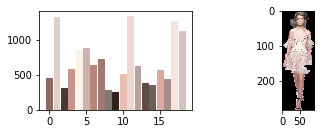

In [104]:
image='./Canny_Filtered_Images/Alexander McQueen_Fall 2016 Ready-to-Wear_Look 24_detected.jpgcanny.jpg'
plt.subplot(223)
centers, labels, counts=dominant_colors(image,plot = True)
img=cv2.imread(image)            # read as BGR
b,g,r = cv2.split(img)       # get b,g,r
img = cv2.merge([r,g,b])         # convert to RGB
plt.subplot(224),plt.imshow(img)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a1d622898>,
 <matplotlib.image.AxesImage at 0x1a21770160>)

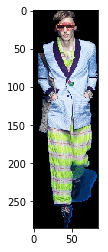

In [71]:
image='./Canny_Filtered_Images/Gucci_Spring 2018 Ready-to-Wear_Look 57_detected.jpgcanny.jpg'
img=cv2.imread(image)            # read as BGR
b,g,r = cv2.split(img)       # get b,g,r
img = cv2.merge([r,g,b])         # convert to RGB
plt.subplot(122),plt.imshow(img)


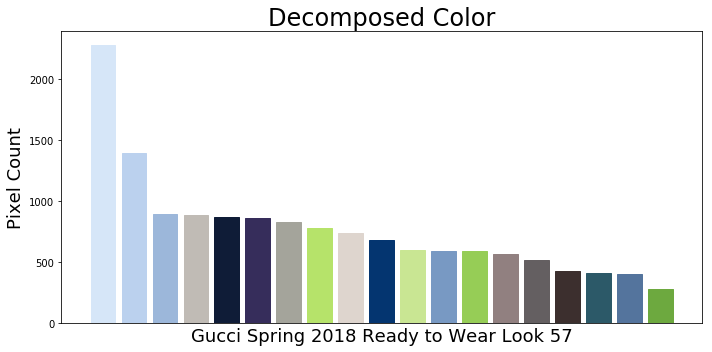

In [70]:
centers=dominant_colors(image,plot = False)
df=centers.sort_values('frequency',ascending=False).reset_index()
plt.figure(figsize = (10,5))
barlist=plt.bar(df.index,df.frequency)
for x in range(0,df.shape[0]):
    barlist[x].set_color(df.original[x]/255)
plt.title('Decomposed Color',fontdict={'fontsize':24})
plt.ylabel('Pixel Count',fontdict={'fontsize':18})
plt.xlabel('Gucci Spring 2018 Ready to Wear Look 57',fontdict={'fontsize':18})
plt.xticks([20])
plt.tight_layout()

plt.show()
